In [16]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from model.neighbors import neighbors

In [17]:
ad_data = ad.read_h5ad("../data/linear.h5ad")
sc.pp.scale(ad_data)
sc.pp.pca(ad_data)

In [31]:
ad_data.obsm['dimred']

array([[-0.3815929336, -0.0727860635,  0.2138916925],
       [-0.2848749114, -0.0635041478,  0.2924044153],
       [-0.0383240769,  0.151737258 ,  0.2995602199],
       ...,
       [-0.4344259409, -0.1743054537,  0.1096827545],
       [-0.0187494414,  0.1798963358,  0.3282723964],
       [-0.3721900869,  0.0833865747,  0.194891618 ]])

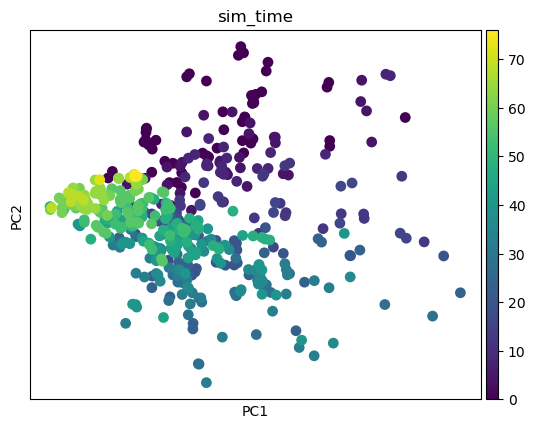

Text(0.5, 1.0, 'Dim reduction of linear data')

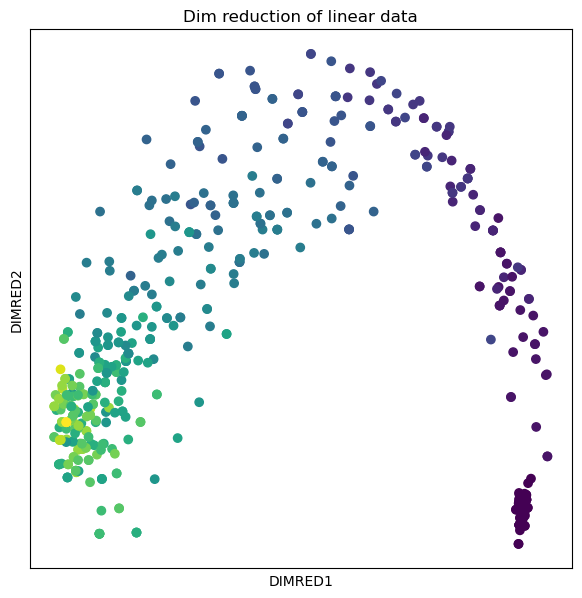

In [54]:
sc.pl.pca(ad_data,color='sim_time')
ad_data.obs['dim1'] = ad_data.obsm['dimred'][:,0]
ad_data.obs['dim2'] = ad_data.obsm['dimred'][:,1]
ad_data.obs['dim3'] = ad_data.obsm['dimred'][:,2]
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(ad_data.obs['dim1'],ad_data.obs['dim2'],c=ad_data.obs['sim_time'],cmap=plt.cm.viridis)
ax.set_xticks([])
ax.set_xlabel("DIMRED1")
ax.set_yticks([])
ax.set_ylabel("DIMRED2")
ax.set_title("Dim reduction of linear data")

In [18]:
ad_data

AnnData object with n_obs × n_vars = 500 × 105
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std'
    uns: 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'pca'
    obsm: 'dimred', 'X_pca'
    varm: 'PCs'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [19]:
big_knn_ad = neighbors(ad_data,n_neighbors=30,n_initial_neighbors=30,use_rep='X',copy=True)
small_knn_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=10,use_rep='X',copy=True)
min_trimed_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=30,scheme="min",use_rep="X",copy=True)
max_trimed_ad = neighbors(ad_data,n_neighbors=10,n_initial_neighbors=30,scheme="max",use_rep="X",copy=True)


100%|██████████| 500/500 [00:24<00:00, 20.42it/s]


In [20]:
knn_graph = big_knn_ad.obsp['distances']
knn_graph_small = small_knn_ad.obsp['distances']
min_curv_graph = min_trimed_ad.obsp['distances']
max_curv_graph = max_trimed_ad.obsp['distances']

In [21]:
import networkx as nx
def drawGraph(adj,curvature):
    graph = nx.from_numpy_array(adj)
    curvature_graph = nx.from_numpy_array(curvature)
    edge_value = nx.get_edge_attributes(curvature_graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    plt.show()
    return

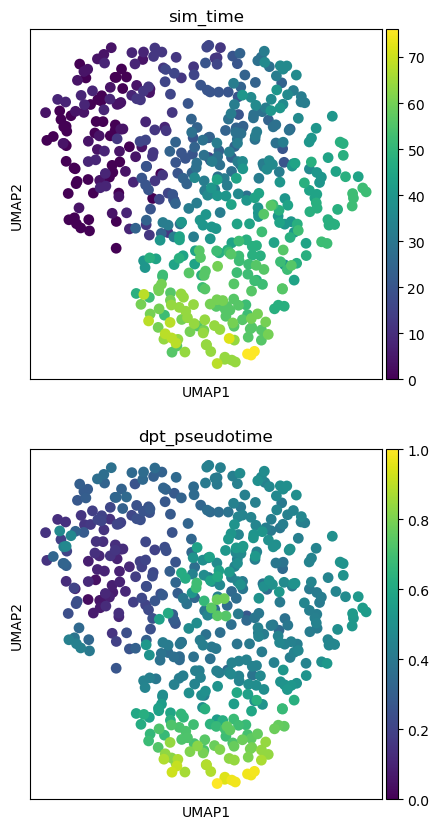

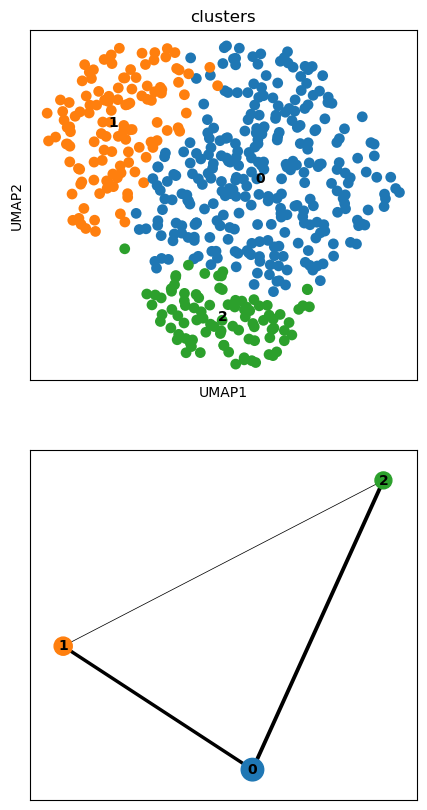

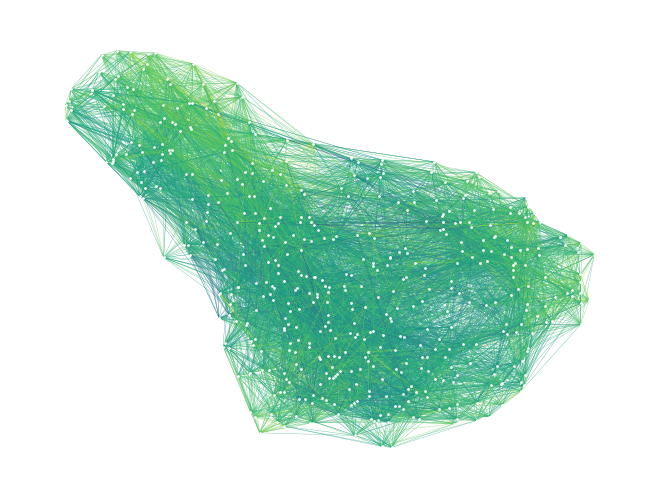

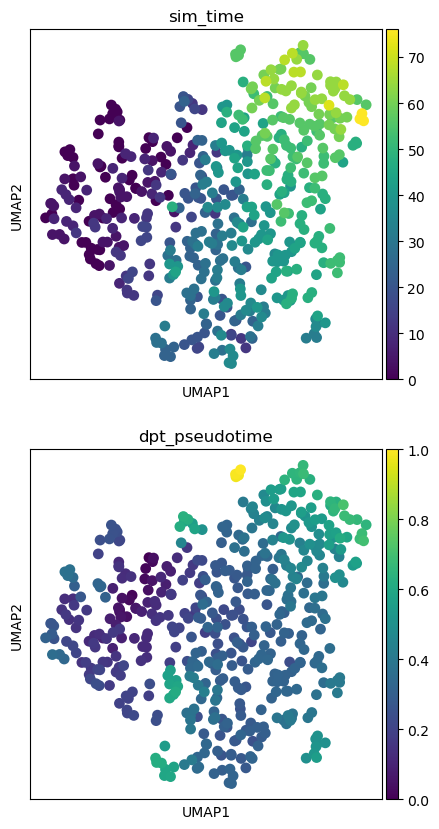

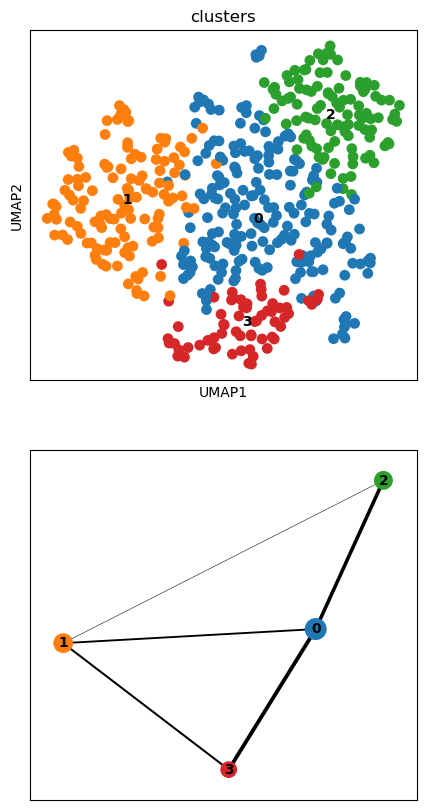

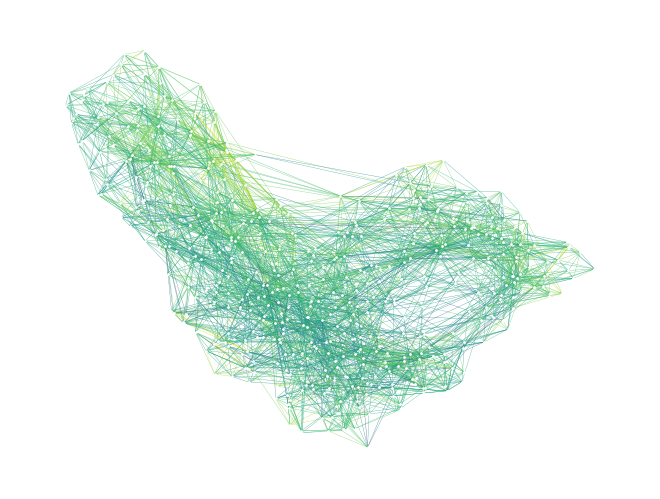

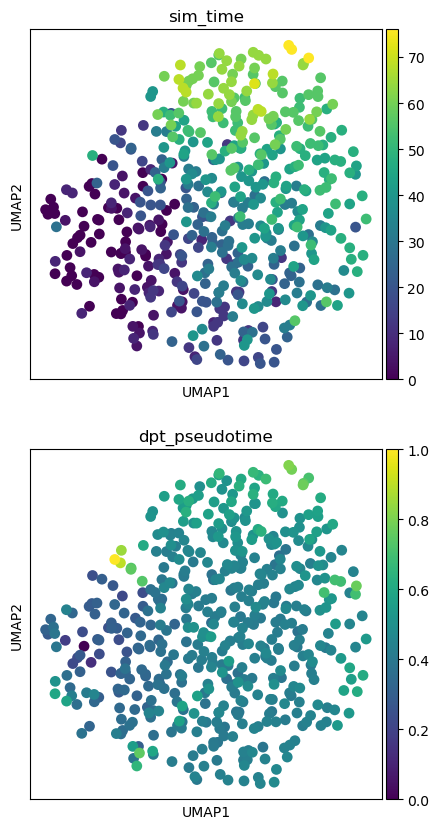

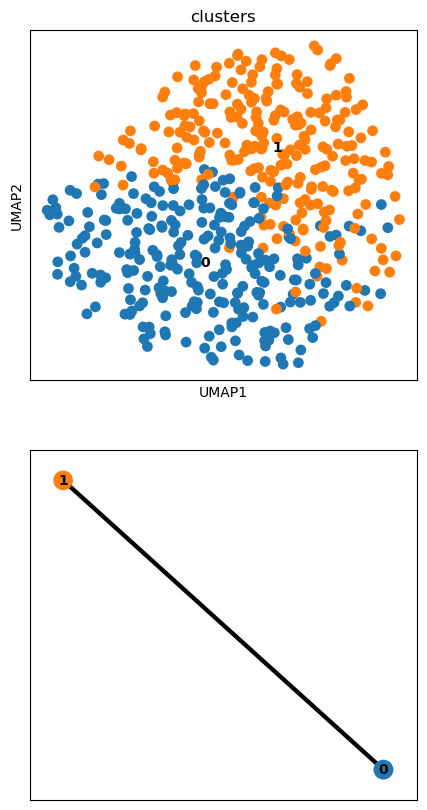

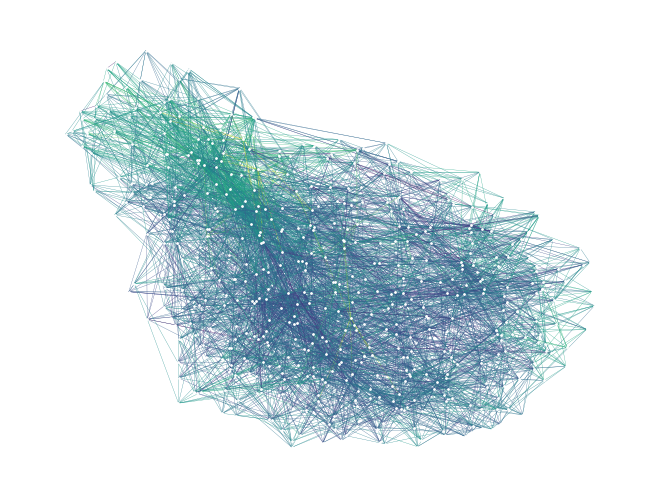

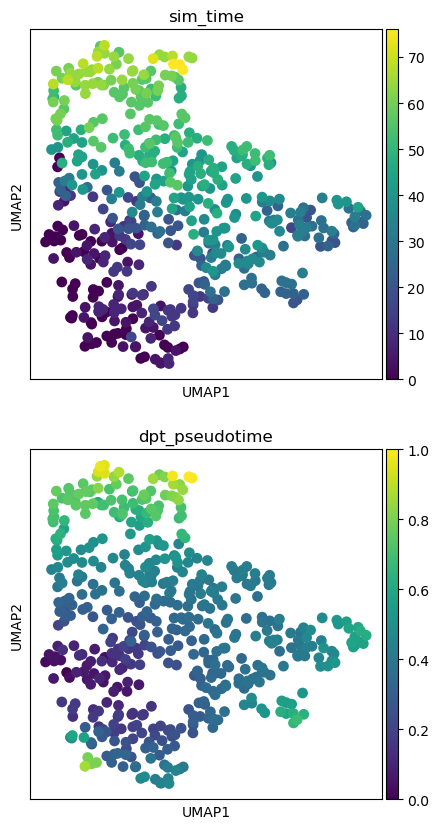

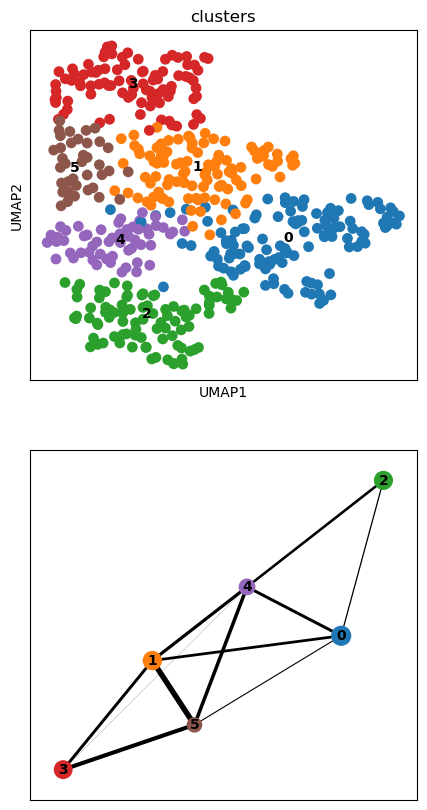

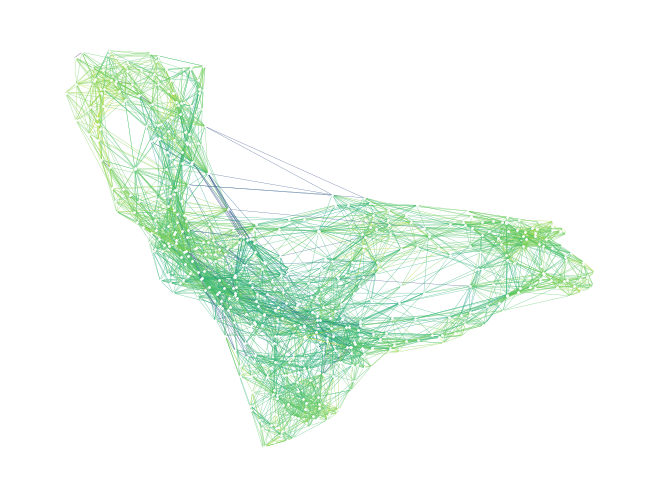

In [28]:
def plotPseudoTime(data):
    point_ad = data.copy()
    sc.tl.draw_graph(point_ad)
    sc.tl.louvain(adata=point_ad,resolution=0.5,key_added='clusters')
    root = np.argmin(point_ad.obs['sim_time'])
    point_ad.uns['iroot'] = root
    #sc.pp.neighbors(point_ad,n_neighbors=20)
    sc.tl.umap(point_ad)
    sc.tl.diffmap(point_ad)
    sc.tl.dpt(point_ad)
    fig_1,axs_1 = plt.subplots(2,1,figsize=(5,10))
    fig_2,axs_2 = plt.subplots(2,1,figsize=(5,10))
    sc.pl.umap(point_ad,color=["sim_time"],legend_loc="on data",ax=axs_1[0],show=False)
    sc.pl.umap(point_ad,color=["clusters"],legend_loc="on data",ax=axs_2[0],show=False)
    sc.pl.umap(point_ad,color=["dpt_pseudotime"],legend_loc="on data",ax=axs_1[1],show=False)
    sc.tl.paga(point_ad,groups='clusters')
    sc.pl.paga(point_ad,ax=axs_2[1],show=False)
    plt.show()
    return
for ad in [big_knn_ad,small_knn_ad,min_trimed_ad,max_trimed_ad]:
    plotPseudoTime(ad)
    drawGraph(ad.obsp["distances"],ad.obsp["curvature"])